In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect =True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector= inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
print(f'--------------------')
columns1 = inspector.get_columns('Station')
for c in columns1:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime(Measurement.date) >= '2016-08-23').all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(last_12)
dropna = df.dropna()
date_grouped = dropna.groupby(['date'])['prcp'].sum()
date_grouped = pd.DataFrame(date_grouped)
date_grouped = date_grouped.sort_values('date', ascending=False)
date_grouped

,prcp
date,
2017-08-23,0.53
2017-08-22,0.50
2017-08-21,0.58
2017-08-20,0.01
2017-08-19,0.09
...,...
2016-08-27,0.32
2016-08-26,0.10
2016-08-25,0.54


/Users/lucykaplan/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


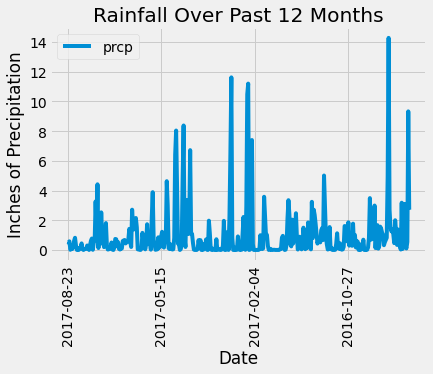

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
date_grouped.plot.line()
plt.xlabel('Date')
plt.ylabel('Inches of Precipitation')
plt.title('Rainfall Over Past 12 Months')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_grouped.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rows = session.query(func.count(Measurement.station), Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(station_rows)

[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]


In [18]:
most_active = session.query(Station).filter(Station.station == "USC00519281")
for station in most_active:
    print(f"The most active station is {station.name}")

The most active station is WAIHEE 837.5, HI US


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()
average = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.station == "USC00519281").first()
print(f'The highest recorded temperature at the most active station was {highest}')
print(f'The highest recorded temperature at the most active station was {lowest}')
print(f'The highest recorded temperature at the most active station was {average}')

The highest recorded temperature at the most active station was (85.0,)
The highest recorded temperature at the most active station was (54.0,)
The highest recorded temperature at the most active station was (72.0,)


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_12 = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime(Measurement.date) >= '2016-08-23').filter(Measurement.station == "USC00519281").all()
df = pd.DataFrame(active_12)

Text(0.5, 1.0, 'Temperature At Most Active Station')

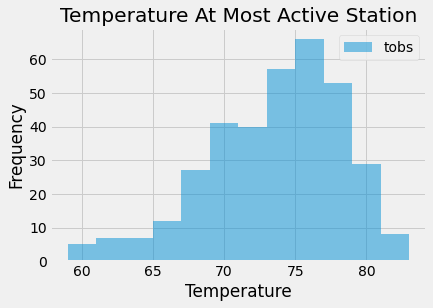

In [21]:
df.plot.hist(bins=12, alpha=0.5)
plt.xlabel('Temperature')
plt.title('Temperature At Most Active Station')

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`


In [30]:
dates = session.query(Measurement.date).all()
dates

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06'),
 ('2010-01-07'),
 ('2010-01-08'),
 ('2010-01-09'),
 ('2010-01-10'),
 ('2010-01-11'),
 ('2010-01-12'),
 ('2010-01-14'),
 ('2010-01-15'),
 ('2010-01-16'),
 ('2010-01-17'),
 ('2010-01-18'),
 ('2010-01-19'),
 ('2010-01-20'),
 ('2010-01-21'),
 ('2010-01-22'),
 ('2010-01-23'),
 ('2010-01-24'),
 ('2010-01-25'),
 ('2010-01-26'),
 ('2010-01-27'),
 ('2010-01-28'),
 ('2010-01-30'),
 ('2010-01-31'),
 ('2010-02-01'),
 ('2010-02-03'),
 ('2010-02-04'),
 ('2010-02-05'),
 ('2010-02-06'),
 ('2010-02-07'),
 ('2010-02-08'),
 ('2010-02-09'),
 ('2010-02-11'),
 ('2010-02-12'),
 ('2010-02-13'),
 ('2010-02-14'),
 ('2010-02-15'),
 ('2010-02-16'),
 ('2010-02-17'),
 ('2010-02-19'),
 ('2010-02-20'),
 ('2010-02-21'),
 ('2010-02-22'),
 ('2010-02-23'),
 ('2010-02-24'),
 ('2010-02-25'),
 ('2010-02-26'),
 ('2010-02-28'),
 ('2010-03-01'),
 ('2010-03-02'),
 ('2010-03-03'),
 ('2010-03-04'),
 ('2010-03-05'),
 ('2010-03-06'),
 ('2010-03-07'

In [38]:
start = "2020-02-16"
for date in dates:
    if date[0] >= start:
        print(date)
        print("")